<a href="https://colab.research.google.com/github/Syam7780/Adosite/blob/main/leafModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image

# Step 1: Define paths for train and validation datasets
train_dir = Path('dataset/train')
val_dir = Path('dataset/validation')

# Step 2: Define transformations for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to fit the input size for pre-trained models
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
])

# Step 3: Helper function to check valid image files
def is_valid_image(file_path):
    """Helper function to check if a file is a valid image."""
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    return file_path.suffix.lower() in valid_extensions

# Step 4: Helper function to create valid image dataset
def make_valid_dataset(directory):
    """Helper function to ensure only valid image files are loaded."""
    valid_images = []
    for class_name in os.listdir(directory):
        class_dir = directory / class_name
        if os.path.isdir(class_dir) and class_name != '.ipynb_checkpoints':
            for img_name in os.listdir(class_dir):
                img_path = class_dir / img_name
                if is_valid_image(img_path):
                    valid_images.append(img_path)
    return valid_images

# Step 5: Load the dataset (train and validation)
train_images = make_valid_dataset(train_dir)
val_images = make_valid_dataset(val_dir)

# Step 6: Custom Dataset class to load images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Read the image using plt.imread (which returns a NumPy array)
        image = plt.imread(image_path)

        # Convert the NumPy array to a PIL Image
        image = Image.fromarray(image)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        # Assign label (healthy: 0, disease: 1)
        label = 0 if 'healthy' in str(image_path) else 1
        return image, label

# Step 7: Create DataLoader for training and validation data
batch_size = 32
train_dataset = CustomImageDataset(train_images, transform=transform)
val_dataset = CustomImageDataset(val_images, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Step 8: Load a pretrained model (ResNet-18 in this case)
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes (2: Healthy and Disease)
num_classes = 2  # Healthy and Disease
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Step 9: Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 10: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 11: Training and validation loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy*100:.2f}%")

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

        # Save the model if the validation accuracy improves
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_leaf_disease_model.pth')
            print(f"Model saved with accuracy: {val_accuracy * 100:.2f}%")

    print(f"Training completed. Best validation accuracy: {best_accuracy * 100:.2f}%")

# Step 12: Train the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.6530, Train Accuracy: 60.00%
Validation Accuracy: 100.00%
Model saved with accuracy: 100.00%
Epoch [2/10], Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [3/10], Train Loss: 0.0003, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [4/10], Train Loss: 0.0001, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [5/10], Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [6/10], Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch [10/10], Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Training completed. Best validation accuracy: 100.00%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Checking directory: dataset/test/.ipynb_checkpoints
Checking directory: dataset/test/healthy
Skipping invalid image: dataset/test/healthy/.ipynb_checkpoints
Valid image found: dataset/test/healthy/lpu_rdp_h100.jpeg
Valid image found: dataset/test/healthy/lpu_rdp_h102.jpeg
Valid image found: dataset/test/healthy/lpu_rdp_h103.jpeg
Checking directory: dataset/test/disease
Skipping invalid image: dataset/test/disease/.ipynb_checkpoints
Valid image found: dataset/test/disease/img10.jpeg
Valid image found: dataset/test/disease/img8.jpeg
Valid image found: dataset/test/disease/img9.jpeg
Number of images in the test set: 6


Test Accuracy: 100.00%


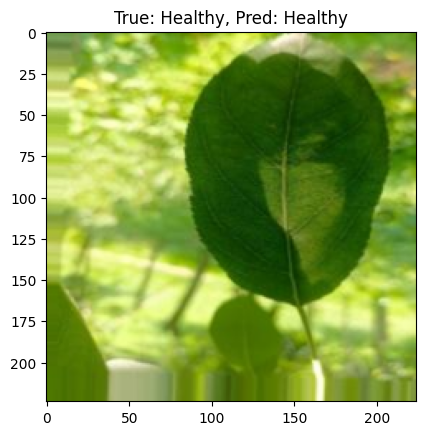

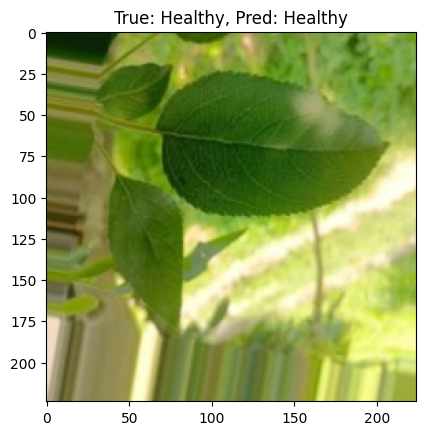

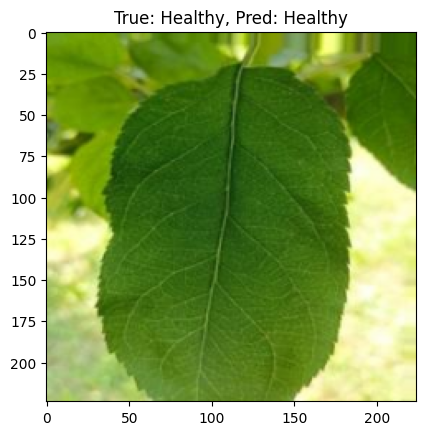

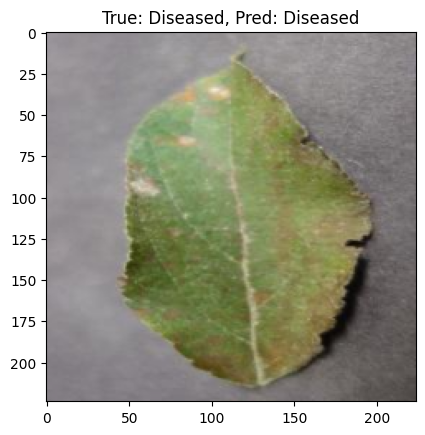

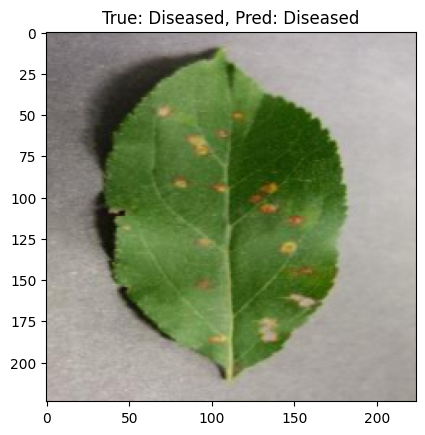

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Step 1: Define the transformation (same as the one used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size of the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization as during training
])

# Step 2: Define the test dataset directory
test_dir = Path('dataset/test')  # Path to your test dataset

def is_valid_image(file_path):
    """Helper function to check if a file is a valid image."""
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    return file_path.suffix.lower() in valid_extensions

def make_valid_dataset(directory):
    """Helper function to ensure only valid image files are loaded."""
    valid_images = []
    for class_name in os.listdir(directory):
        class_dir = directory / class_name
        print(f"Checking directory: {class_dir}")  # Debug print
        if os.path.isdir(class_dir) and class_name != '.ipynb_checkpoints':
            for img_name in os.listdir(class_dir):
                img_path = class_dir / img_name
                if is_valid_image(img_path):
                    valid_images.append(img_path)
                    print(f"Valid image found: {img_path}")  # Debug print
                else:
                    print(f"Skipping invalid image: {img_path}")  # Debug print
    return valid_images

# Step 3: Load test images
test_images = make_valid_dataset(test_dir)

# Debug print to check how many images are loaded
print(f"Number of images in the test set: {len(test_images)}")

# Step 4: Check if the test set is empty
if len(test_images) == 0:
    print("Error: No valid images found in the test dataset!")
    exit()  # Exit if no images are found

# Step 5: Create DataLoader for the test set
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = plt.imread(image_path)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # Assign label (healthy: 0, disease: 1)
        label = 0 if 'healthy' in str(image_path) else 1
        return image, label

# Step 6: Create DataLoader for test set
test_dataset = CustomImageDataset(test_images, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 7: Load the trained model (load saved weights)
model = models.resnet18(pretrained=False)  # No pre-trained weights because we will load custom weights
num_classes = 2  # Healthy and Disease
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the trained model weights (fix for warning)
model.load_state_dict(torch.load('best_leaf_disease_model.pth', weights_only=True))

# Step 8: Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 9: Put the model in evaluation mode
model.eval()

# Step 10: Run inference on the test dataset
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Step 11: Calculate and print the accuracy
if total > 0:
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
else:
    print("Error: No images processed during testing.")

# Optional: Visualize some test images with predictions
def imshow(img, label, pred):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy for plotting Healthy
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    plt.imshow(img)
    plt.title(f"True: {'Healthy' if label == 0 else 'Diseased'}, Pred: {'Healthy' if pred == 0 else 'Diseased'}")
    plt.show()


for i in range(5):
    inputs, labels = test_dataset[i]
    inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
    labels = labels  # No need to apply unsqueeze to the label

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    imshow(inputs[0], labels, predicted.item())
